```{eval-rst}
.. include:: ../sinebow.rst

```
{header-2}`Omnipose in 3D`
==========================

You can use the `dim` (dimension) argument to tell Omnipose to segment your images using a 3D model. This means that an image stack or 3D array is treated as a 3D volume given to a network trained on 3D volumes. This is very different from `do_3D` in Cellpose, which cleverly leveraged 2D predictions on all 2D slices of a 3D volume to construct a 3D flow field for segmentation. It turns out that the pseudo-ND Cellpose flows are an approximation to the true 3D flows of Omnipose, because the flows in each slice point to a local center of the cell, a.k.a. the cell skeleton to which the Omnipose field points. Thus, is not recommended to use Omnipose 2D slice predictions with `do_3D`. Instead, this notebook assumes you have trained a 3D model such as the `plant_omni` model.

In [ ]:
# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2

In [ ]:
# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline

## Read in data
Here I am choosing one of the scaled-down volumes of the plant *Arabidopsis thaliana* dataset we used in the Omnipose paper. 

In [ ]:
from pathlib import Path
import os
from cellpose_omni import io
import omnipose
omnidir = Path(omnipose.__file__).parent.parent.parent
basedir = os.path.join(omnidir,'docs','test_files_3D')
files = io.get_image_files(basedir)
files # this displays the variable if it the last thing in the code block

['/home/kcutler/DataDrive/omnipose/docs/test_files_3D/Movie1_t00004_crop_gt.tif']

In [ ]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99

imgs = [io.imread(f) for f in files]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range:', i.min(),i.max())
nimg = len(imgs)
print('number of images:',nimg)

Original image shape: (162, 207, 443)
data type: uint8
data range: 0 247
number of images: 1


## Initialize model
`plant_omni` is the model trained on these plant cell images. (The image we loaded is from the test set, of course.)

In [ ]:
from cellpose_omni import models
model_name = 'plant_omni'

dim = 3
nclasses = 3 # flow + dist + boundary
nchan = 1
omni = 1
rescale = False
diam_mean = 0
use_GPU = 0 # Most people do not have enough VRAM to run on GPU... 24GB not enough for this image, need nearly 48GB
model = models.CellposeModel(gpu=use_GPU, model_type=model_name, net_avg=False, 
                             diam_mean=diam_mean, nclasses=nclasses, dim=dim, nchan=nchan)

2025-07-18 00:29:11,189	[INFO]     cellpose_omni/models.py       __init__....()	 line 436	>>plant_omni<< model set to be used
2025-07-18 00:29:11,190	[INFO]                                   cach..._path()	 line  63	Downloading: "https://raw.githubusercontent.com/kevinjohncutler/omnipose-models/main/plant_omnitorch_0" to /home/kcutler/.cellpose/models/plant_omnitorch_0

https://raw.githubusercontent.com/kevinjohncutler/omnipose-models/main/plant_omnitorch_0 /home/kcutler/.cellpose/models/plant_omnitorch_0


100%|██████████████████████████████████████| 71.6M/71.6M [00:05<00:00, 13.3MB/s]

2025-07-18 00:29:20,054	[INFO]     cellpose_omni/core.py         assi...evice()	 line  72	Using CPU.


2025-07-18 00:29:20,125	[INFO]                                   __init__....()	 line 173	u-net config: ([1, 32, 64, 128, 256], 5, 3)


## Run segmentation 

In [ ]:
import torch
torch.cuda.empty_cache()
mask_threshold = -5 #usually this is -1
flow_threshold = 0.
diam_threshold = 12
net_avg = False
cluster = False
verbose = 1
tile = 0
chans = None
compute_masks = 1
resample=False
rescale=None
omni=True
flow_factor = 10 # multiple to increase flow magnitude, useful in 3D
transparency = True

nimg = len(imgs)
masks_om, flows_om = [[]]*nimg,[[]]*nimg

# splitting the images into batches helps manage VRAM use so that memory can get properly released 
# here we have just one image, but most people will have several to process
for k in range(nimg):
    masks_om[k], flows_om[k], _ = model.eval(imgs[k],
                                             channels=chans,
                                             rescale=rescale,
                                             mask_threshold=mask_threshold,
                                             net_avg=net_avg,
                                             transparency=transparency,
                                             flow_threshold=flow_threshold,
                                             omni=omni,
                                             resample=resample,
                                             verbose=verbose,
                                             diam_threshold=diam_threshold,
                                             cluster=cluster,
                                             niter=10,
                                             tile=tile,
                                             compute_masks=compute_masks,
                                             flow_factor=flow_factor) 

2025-07-18 00:29:21,668	[INFO]     cellpose_omni/models.py       eval........()	 line 696	is_grey False, slice_ndim 3, dim 3, nchan 1, is_list False
2025-07-18 00:29:21,669	[INFO]                                               	 line 707	is_image True, is_stack False, is_list False
2025-07-18 00:29:21,669	[INFO]                                               	 line 729	Evaluating with flow_threshold 0.00, mask_threshold -5.00
2025-07-18 00:29:21,669	[INFO]                                               	 line 731	using omni model, cluster False
2025-07-18 00:29:21,670	[INFO]                                               	 line 1133	not using dataparallel
2025-07-18 00:29:21,670	[INFO]                                               	 line 1136	network initialized.
2025-07-18 00:29:21,772	[INFO]                                               	 line 1143	shape before transforms.convert_image(): (162, 207, 443)
2025-07-18 00:29:21,773	[INFO]                                               	 line 

## Plot results
3D segmentation is a lot harder to show than 2D. If anyone figures out a good way to use one of the many tools out there (`ipyvolume`, `K3D-Jupyter`, `itkwidgets`, `ipygany`) for *label* visualization (not image volumes), please let me know. Few of these are in active development, and my own 3D work requires robust label editing tools anyway, which I do not think any available tools offer. Hence I shall just load in Napari and show you an auto-captured screenshot. 

In [ ]:
%%capture
import ncolor
mask = masks_om[0]
mask_nc = ncolor.label(mask,max_depth=20)

import napari
viewer = napari.view_labels(mask_nc);
viewer.dims.ndisplay = 3
viewer.camera.center = [s//2 for s in mask.shape]
viewer.camera.zoom=1
viewer.camera.angles=(10.90517458968619, -20.777067798396835, 58.04311170773853)
viewer.camera.perspective=0.0
viewer.camera.interactive=True

img = viewer.screenshot(size=(1000,1000),scale=1,canvas_only=True,flash=False)

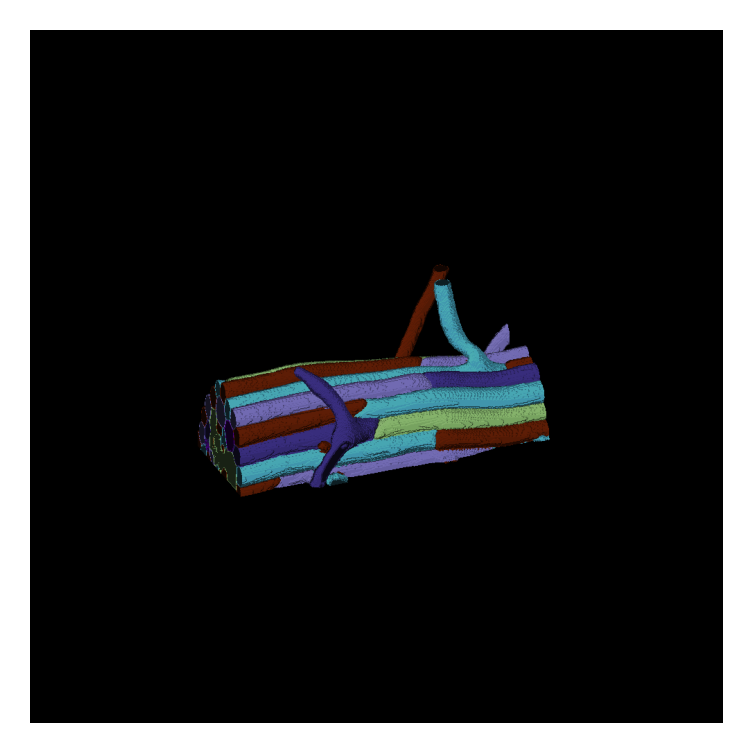

In [ ]:
plt.figure(figsize=(3,3),frameon=False)
plt.imshow(img)
plt.axis('off')
plt.show()

## Plot orthogonal slices

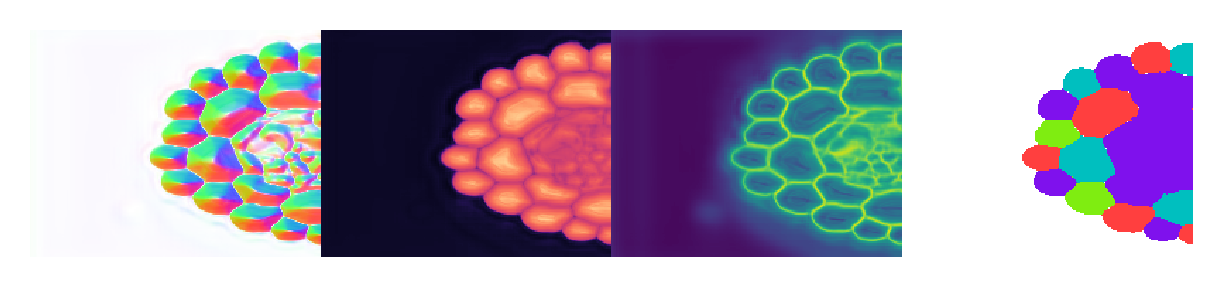

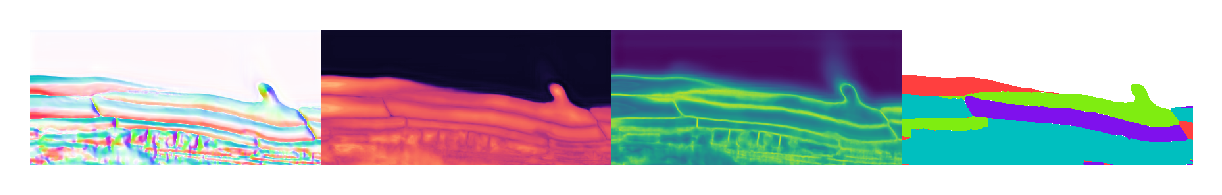

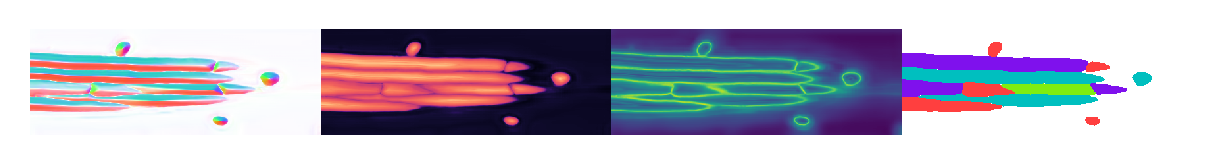

In [ ]:
from cellpose_omni import plot
from omnipose.plot import apply_ncolor

mu = flows_om[0][1]
T = flows_om[0][2]
bd = flows_om[0][4]
# mu.shape,T.shape,bd.shape

d = mu.shape[0]

from omnipose.utils import rescale
c = np.array([1]*2+[0]*(d-2))
# c = np.arange(d)
def cyclic_perm(a):
    n = len(a)
    b = [[a[i - j] for i in range(n)] for j in range(n)]
    return b
slices = []
idx = np.arange(d)
cmap = mpl.colormaps['magma']
cmap2 = mpl.colormaps['viridis']

for inds in cyclic_perm(c):
    slc = tuple([slice(-1) if i else mu.shape[k+1]//2 for i,k in zip(inds,idx)])
    flow = plot.dx_to_circ(mu[np.where(inds)+slc],transparency=1)/255
    dist = cmap(rescale(T)[slc])
    bnds = cmap2(rescale(bd)[slc])
    msks = apply_ncolor(masks_om[0][slc])

    fig = plt.figure(figsize=[5]*2,frameon=False)
    plt.imshow(np.hstack((flow,dist,bnds,msks)),interpolation='none')
    plt.axis('off')
    plt.show()
    

### Notes on the above
Slices do not always look crisp because we are cutting though boundaries. At these locations, the flow and distance fields darken and the boundary field brightens. This can result in flat and muddled regions that are hard to interpret. Again, interactive 3D visualization tools are needed to properly evaluate the results of the segmentation. In this case, we have cut through the middle of enough cells to confirm that the output looks reasonable. 

This small dataset with problematic annotations was sufficient for demonstrating that Omnipose *can* be used on 3D data, but I again emphasize that any algorithm will only work *well* after training on well-annotated, representative examples. In this case, small cell clusters were neither well-annotated nor well-represented in the training set, and you can see the negative impact of that in this example. 

These 3D models are incredibly VRAM-hungry, so all results in the paper were actually run on an AWS instance. Here I ran them on CPU, which is much slower but necessary to do even with a 24GB Titan RTX. 



### Running Omnipose with do_3D

`do_3D` is not something you want to use with *any* Omnipose model, but you might want to use it with a 2D Cellpose model for 3D cells with extended shapes. This is because `do_3D` computes 2D flow fields from every yx, yz, and xz slice of the image and composites these components into a 3D field. It turns out that the center-seeking flow slices of Cellpose end up pointing roughly toward the local 3D skeleton, i.e. the `do_3D` Cellpose composite field approximates the true 3D flows of Omnipose. The 2D Omnipose field, on the other hand, cannot be composited into a useful 3D field. 

Althought the `do_3D` Cellpose field directs pixels toward the skeleton, the stock Cellpose mask reconstruction algorithm tends to oversegment pixels into clusters along the skeleton. To avoid this, you can use a Cellpose model but with Omnipose mask reconstruciton by usin {py}`omni=True`. Here is how to do this.


In [ ]:
from cellpose_omni import models, core

# define cellpose model
model_name = 'plant_cp'

# this model was trained on 2D slices 
dim = 2 
nclasses = 2 # cellpose models have no boundary field, just flow and distance 

# Cellpose defaults to 2 channels; 
# this is the setup for grayscale in that case
nchan = 2
chans = [0,0]

# no rescaling for this model
diam_mean = 0


use_GPU = core.use_gpu()
model = models.CellposeModel(gpu=use_GPU, model_type=model_name, net_avg=False, 
                             diam_mean=diam_mean, nclasses=nclasses, dim=dim, nchan=nchan)


# segmentation parameters 
omni = 1
rescale = False
mask_threshold = 0 
net_avg = 0
verbose = 1
tile = 0
compute_masks = 1
rescale = None
flow_threshold=0.
do_3D=True
flow_factor=10

masks_cp, flows_cp, _ = model.eval(imgs,
                                   channels=chans,
                                   rescale=rescale,
                                   mask_threshold=mask_threshold,
                                   net_avg=net_avg,
                                   transparency=True, 
                                   flow_threshold=flow_threshold,
                                   verbose=verbose, 
                                   tile=tile,
                                   compute_masks=compute_masks, 
                                   do_3D=True, 
                                   omni=omni,
                                   flow_factor=flow_factor)

2025-07-18 00:30:06,701	[INFO]     cellpose_omni/models.py       __init__....()	 line 436	>>plant_cp<< model set to be used
2025-07-18 00:30:06,701	[INFO]                                   cach..._path()	 line  63	Downloading: "https://raw.githubusercontent.com/kevinjohncutler/omnipose-models/main/plant_cptorch_0" to /home/kcutler/.cellpose/models/plant_cptorch_0

https://raw.githubusercontent.com/kevinjohncutler/omnipose-models/main/plant_cptorch_0 /home/kcutler/.cellpose/models/plant_cptorch_0


100%|██████████████████████████████████████| 25.3M/25.3M [00:00<00:00, 32.0MB/s]

2025-07-18 00:30:08,286	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-07-18 00:30:08,317	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 3, 2)
2025-07-18 00:30:08,356	[INFO]     cellpose_omni/models.py       eval........()	 line 696	is_grey True, slice_ndim 3, dim 2, nchan 2, is_list True
2025-07-18 00:30:08,357	[INFO]                                               	 line 707	is_image False, is_stack False, is_list True
2025-07-18 00:30:08,357	[INFO]                                               	 line 1064	Evaluating one image at a time


2025-07-18 00:30:08,358	[INFO]                                               	 line 696	is_grey True, slice_ndim 3, dim 2, nchan 2, is_list False
2025-07-18 00:30:08,358	[INFO]                                               	 line 707	is_image True, is_stack False, is_list False
2025-07-18 00:30:08,358	[INFO]                                               	 line 729	Evaluating with flow_threshold 0.00, mask_threshold 0.00
2025-07-18 00:30:08,359	[INFO]                                               	 line 731	using omni model, cluster False
2025-07-18 00:30:08,359	[INFO]                                               	 line 1124	using dataparallel
2025-07-18 00:30:08,359	[INFO]                                               	 line 1136	network initialized.
2025-07-18 00:30:08,396	[INFO]                                               	 line 1143	shape before transforms.convert_image(): (162, 207, 443)
2025-07-18 00:30:08,396	[INFO]                                               	 line 1144	mod

##  Compare masks to ground truth 

In [ ]:
from fastremap import unique
mgt = io.imread(files[0][:-4]+'_masks.tif')
print('Cellpose do_3D + omni=True: {} masks. \nOmnipose 3D: {} masks. \nGround truth: {} masks'.format(len(unique(masks_cp[0])),
                                                                                                    len(unique(masks_om[0])), 
                                                                                                    len(unique(mgt))))

Cellpose do_3D + omni=True: 75 masks. 
Omnipose 3D: 113 masks. 
Ground truth: 67 masks


For what it's worth, pure Cellpose gives ~550 masks in this volume, pure Omnipose gives ~200, and Cellpose model + Omnipose mask reconstruction gives ~50. I'm sorry to say that the ground truth for this dataset is quite bad, containing some undersegmented cells, but more importantly, an entire "ignore" region where there are many, many cells that are unlabeled. So the count of 67 cells in the ground truth refers only to the long cells on the outside of the root. Thus, 55 cells is a severe under-segmentation of the volume. Let's see why. 


## Plot results (analysis)


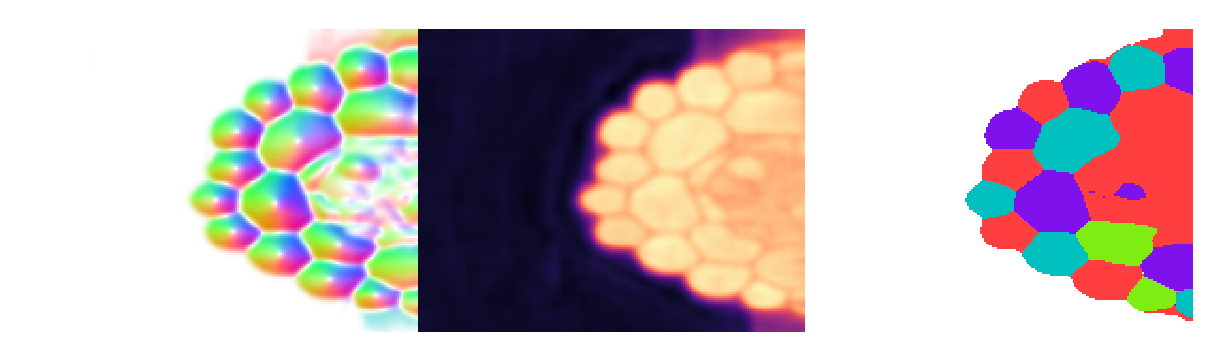

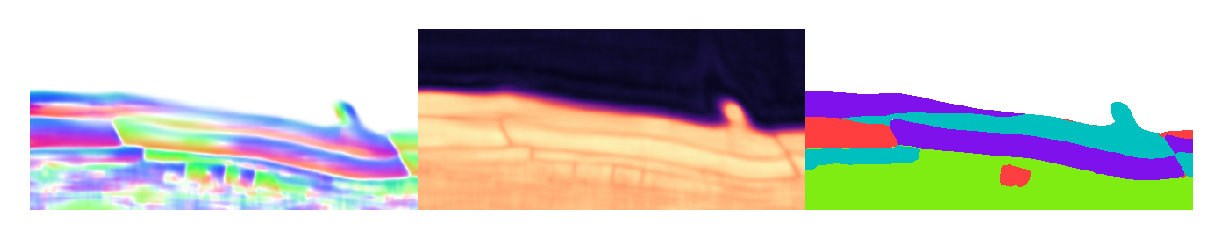

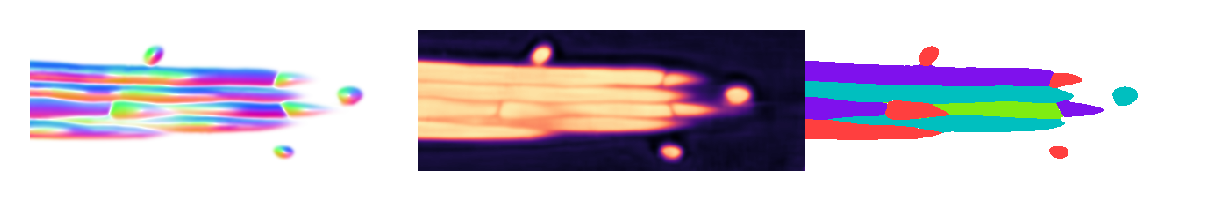

In [ ]:
from cellpose_omni import plot
from omnipose.plot import apply_ncolor

mu = flows_cp[0][1]
T = flows_cp[0][2]
bd = flows_cp[0][4]
# mu.shape,T.shape,bd.shape

d = mu.shape[0]

from omnipose.utils import rescale
c = np.array([1]*2+[0]*(d-2))
# c = np.arange(d)
def cyclic_perm(a):
    n = len(a)
    b = [[a[i - j] for i in range(n)] for j in range(n)]
    return b
slices = []
idx = np.arange(d)
cmap = mpl.colormaps['magma']
cmap2 = mpl.colormaps['viridis']

for inds in cyclic_perm(c):
    slc = tuple([slice(-1) if i else mu.shape[k+1]//2 for i,k in zip(inds,idx)])
    flow = plot.dx_to_circ(mu[np.where(inds)+slc],transparency=1)/255
    dist = cmap(rescale(T)[slc])
    msks = apply_ncolor(masks_cp[0][slc])

    fig = plt.figure(figsize=[5]*2,frameon=False)
    plt.imshow(np.hstack((flow,dist,msks)),interpolation='none')
    
    plt.axis('off')
    plt.show()

In [ ]:
%%capture
import ncolor
mask = masks_cp[0]
mask_nc = ncolor.label(mask,max_depth=20)

import napari
viewer = napari.view_labels(mask_nc);
viewer.dims.ndisplay = 3
viewer.camera.center = [s//2 for s in mask.shape]
viewer.camera.zoom=1
viewer.camera.angles=(10.90517458968619, -20.777067798396835, 58.04311170773853)
viewer.camera.perspective=0.0
viewer.camera.interactive=True

img = viewer.screenshot(size=(1000,1000),scale=1,canvas_only=True,flash=False)

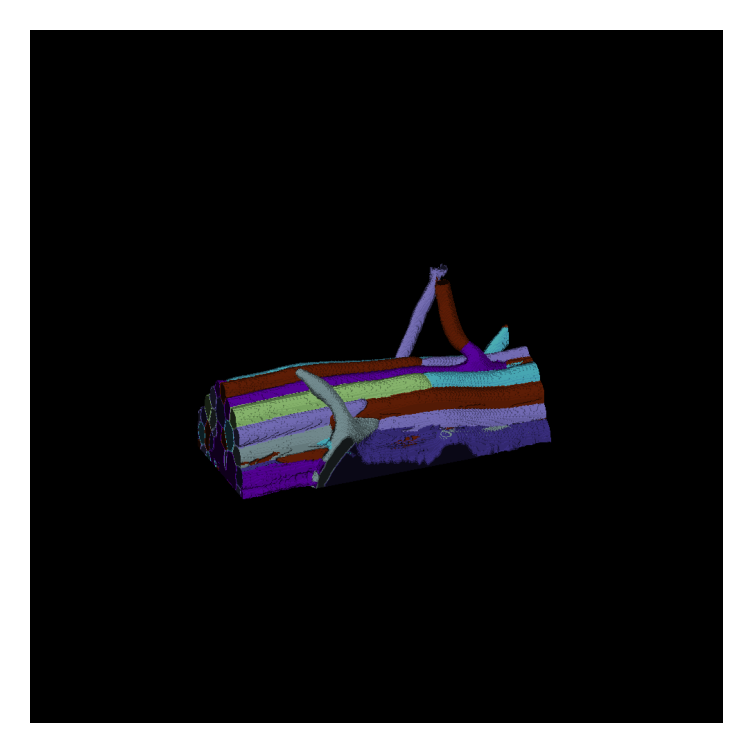

In [ ]:
plt.figure(figsize=(3,3),frameon=False)
plt.imshow(img)
plt.axis('off')
plt.show()

It appears that {py}`omni=True` does allow 2D Cellpose models to work in 3D, but the prediction quality - worsened by artifacts introduced by the compoisiting into 3D - is a limiting factor. 

In [ ]:
imgs[0].shape

(162, 207, 443)